# Modelling

## Summary

### Import libraries and data

### Modelling strategy

### Check for stationarity  (dickey-fuller test)

### Find optimal seasonal length

### Time series decomposition

### Implementing SARIMAX models
1. Time series report function
2. Baseline model function
3. Model test function

### Experiment with model parameters, evaluate best models

### Model round up
1. Evaluation of scores
2. Plot forecasts for one step ahead vs real
3. Plot forecasts and calculate r2 value of two step ahead forecasts

### Conclusion
1. Evaluation of commercial viability of models
2. Improvements for future iterations or commercial roll out



## Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from plotly import tools
import networkx as nx

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)


## Import and format data

In [2]:
#import data
all_traffic=pd.read_csv('all_players_modelling_df.csv')
rec_traffic=pd.read_csv('recreational_players_modelling_df.csv')
pros_online=pd.read_csv('pros_online_modelling_df.csv')

In [3]:
#drop unnecessary columns and recast to date time
all_traffic=all_traffic[['date_time','game_count']]
all_traffic['date_time']=all_traffic['date_time'].apply(pd.Timestamp)
all_traffic.set_index('date_time', inplace=True)
all_traffic.columns=['all_games_count']

In [4]:
rec_traffic=rec_traffic[['date_time','game_count']]
rec_traffic['date_time']=rec_traffic['date_time'].apply(pd.Timestamp)
rec_traffic.set_index('date_time', inplace=True)
rec_traffic.columns=['rec_games_count']

In [5]:
pros_online=pros_online[['date_time','pros_online']]
pros_online['date_time']=pros_online['date_time'].apply(pd.Timestamp)
pros_online.set_index('date_time', inplace=True)

### Introduction

With the clean data sets we will now model each time series - all traffic, recreational only traffic, and professionals online per hour.

Given the conclusions from EDA, we know each time series likely has a stationary mean and a daily/weekly seasonal component. We will use the SARIMAX algorithm from stats.models to model the time series.

When making the time series models a primary concern should be end use. Forecasts including the first lag implies a prediction will only become available as the start of the time period in question, this gives the user little time to make strategic adjustments in the face of new information. Also, predictions  will be more volatile for shorter time windows, users may prefer more accurate forecasts that involve larger time windows.

With this in mind we should look to evaluate time series for different window lengths and steps ahead predictions.


## Check for stationarity
Implement the dickey-fuller test on each time series to ensure they have stationary means

In [6]:
# Define funcitons for dickey fuller diagnostics
season=168  #24=1 day, 168= 1 week

def test_stationarity(timeseries,maxlag=None,regression='c',autolag='AIC'):
    '''Perform Dickey-Fuller test and print out results'''
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=maxlag,regression=regression,autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

def rolling(timeseries,window=season,center=True,figsize=(12,8)): 
    '''
    Plot original timeseries, 
    rolling mean over given window size and rolling 
    mean plus/minus standard deviation
    '''
    
    rolmean = timeseries.rolling(window=window, center=center).mean()
    rolstd = timeseries.rolling(window=window, center=center).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=figsize)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std_plus = plt.plot(rolmean+rolstd, color='red',ls='--', label = 'Rolling Mean +/- Rolling Std')
    std_minus = plt.plot(rolmean-rolstd, color='red',ls='--',label= '')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()  

def autocorrelation_plot(timeseries,lags=season):
    '''Plot autocorrelations and partial autocorrelations'''
    fig, ax = plt.subplots(ncols=2,figsize=(12,4))
    plot_acf(timeseries, lags=lags, ax=ax[0])
    plot_pacf(timeseries, lags=lags, ax=ax[1], method='ywmle')
    plt.show()

def test_and_vis(timeseries):
    '''
    Perform Dickey-Fuller test, 
    plot timeseries with rolling mean and autocorrelations
    '''
    test_stationarity(timeseries.dropna())
    rolling(timeseries)
    autocorrelation_plot(timeseries.dropna())

### All traffic

Results of Dickey-Fuller Test:
Test Statistic                -8.687899e+00
p-value                        4.115556e-14
#Lags Used                     2.600000e+01
Number of Observations Used    7.538000e+03
Critical Value (1%)           -3.431218e+00
Critical Value (5%)           -2.861924e+00
Critical Value (10%)          -2.566974e+00
dtype: float64


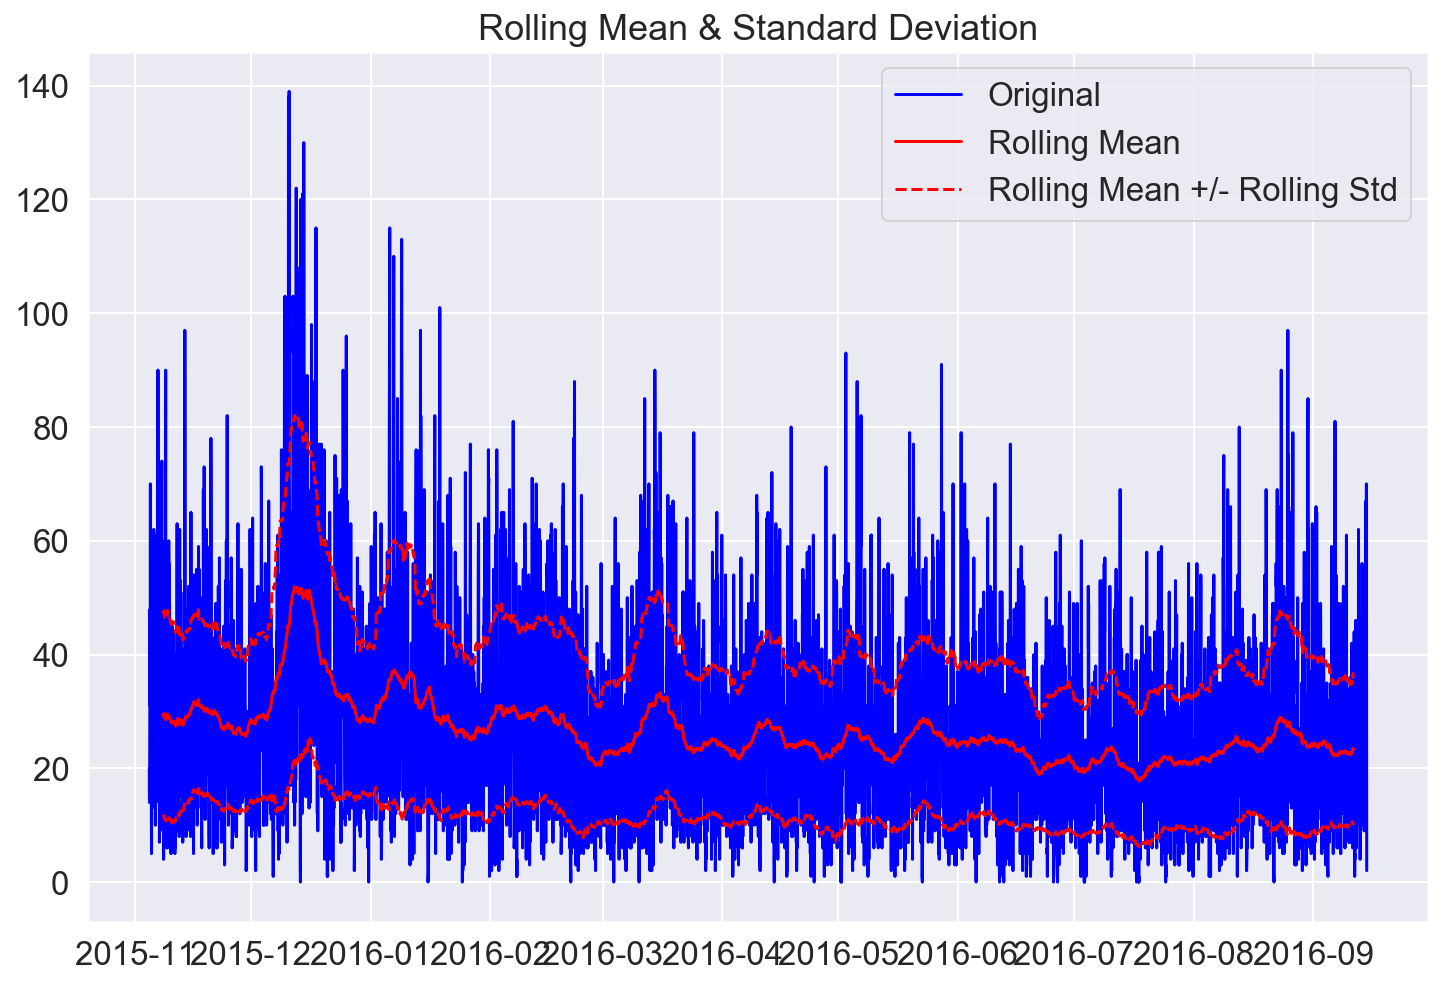

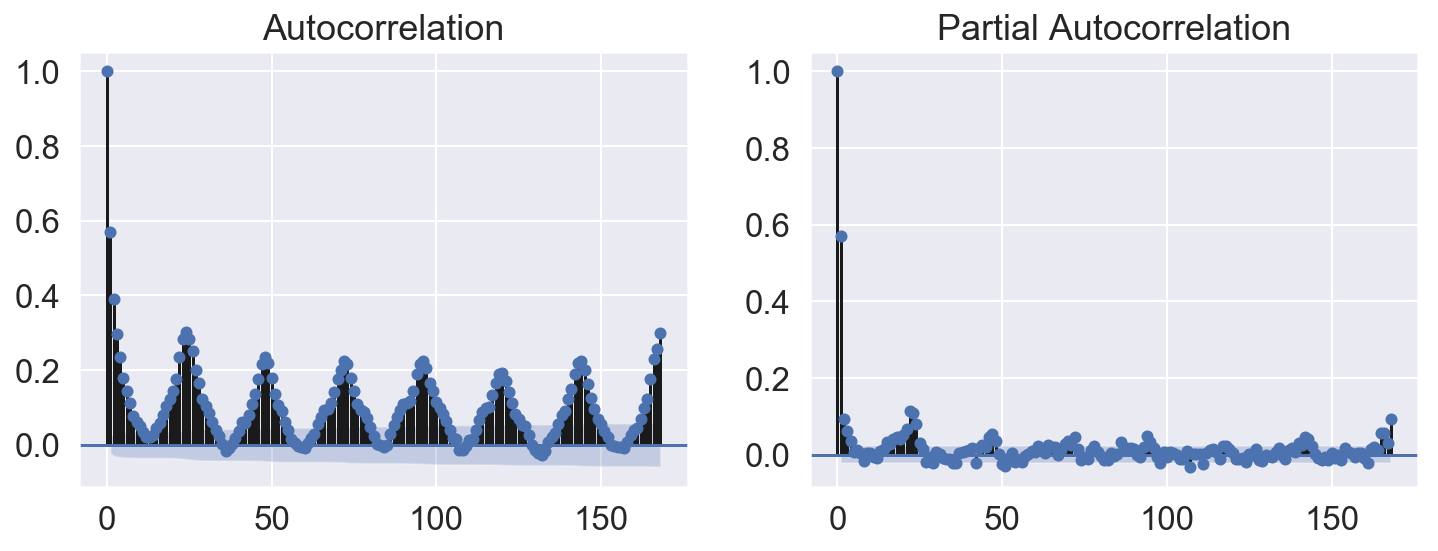

In [7]:
test_and_vis(all_traffic.all_games_count)

### Traffic with at least one recreational player

Results of Dickey-Fuller Test:
Test Statistic                -1.085904e+01
p-value                        1.462324e-19
#Lags Used                     2.700000e+01
Number of Observations Used    7.537000e+03
Critical Value (1%)           -3.431218e+00
Critical Value (5%)           -2.861924e+00
Critical Value (10%)          -2.566974e+00
dtype: float64


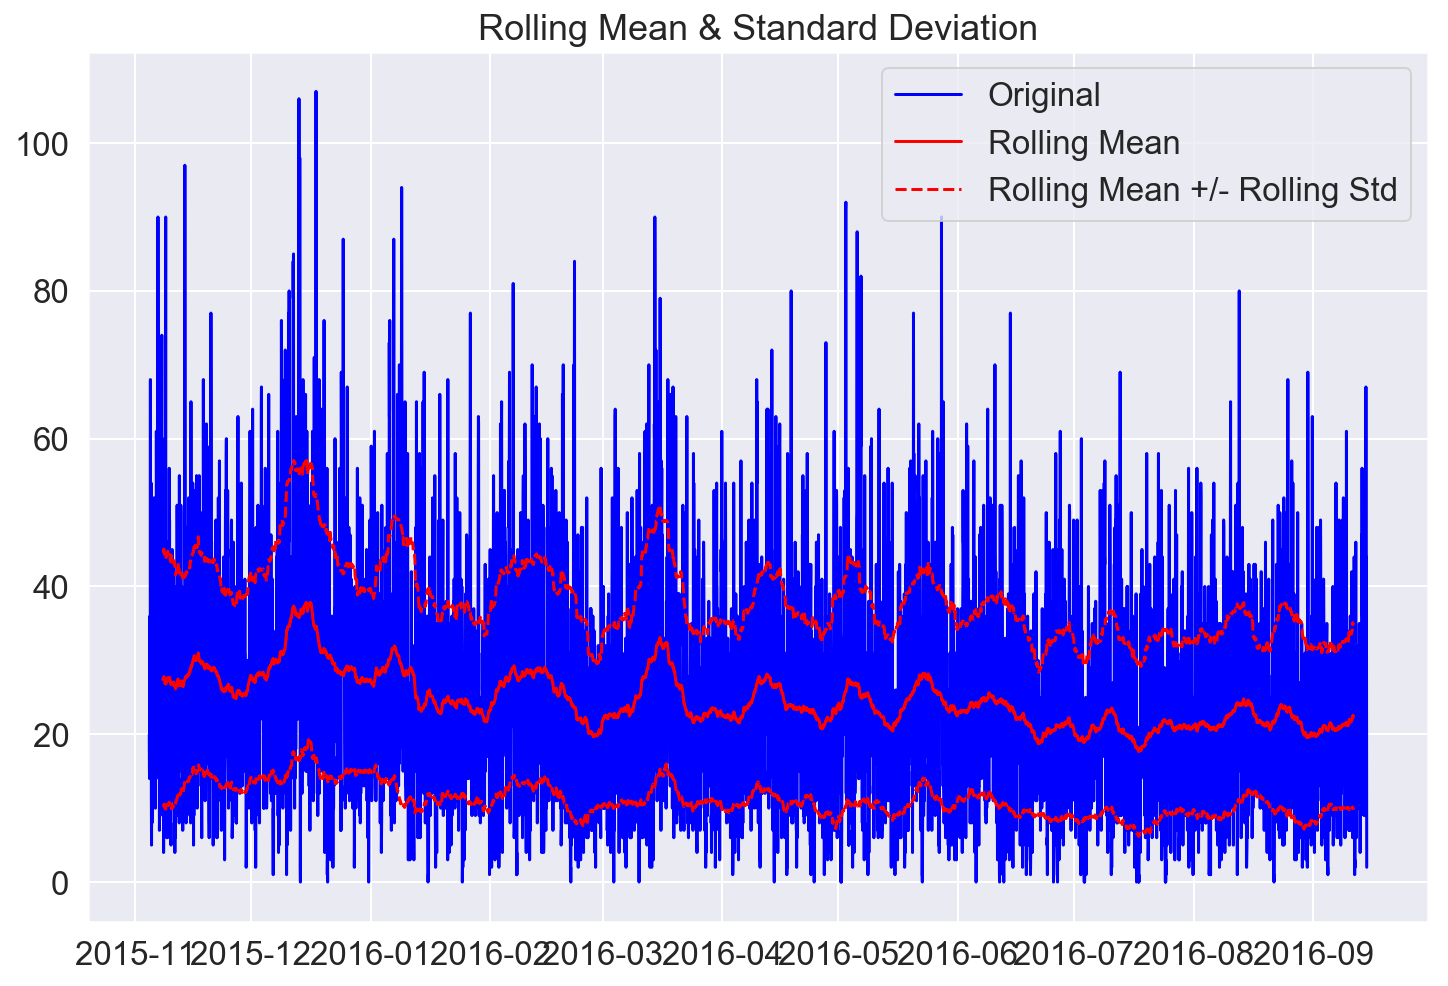

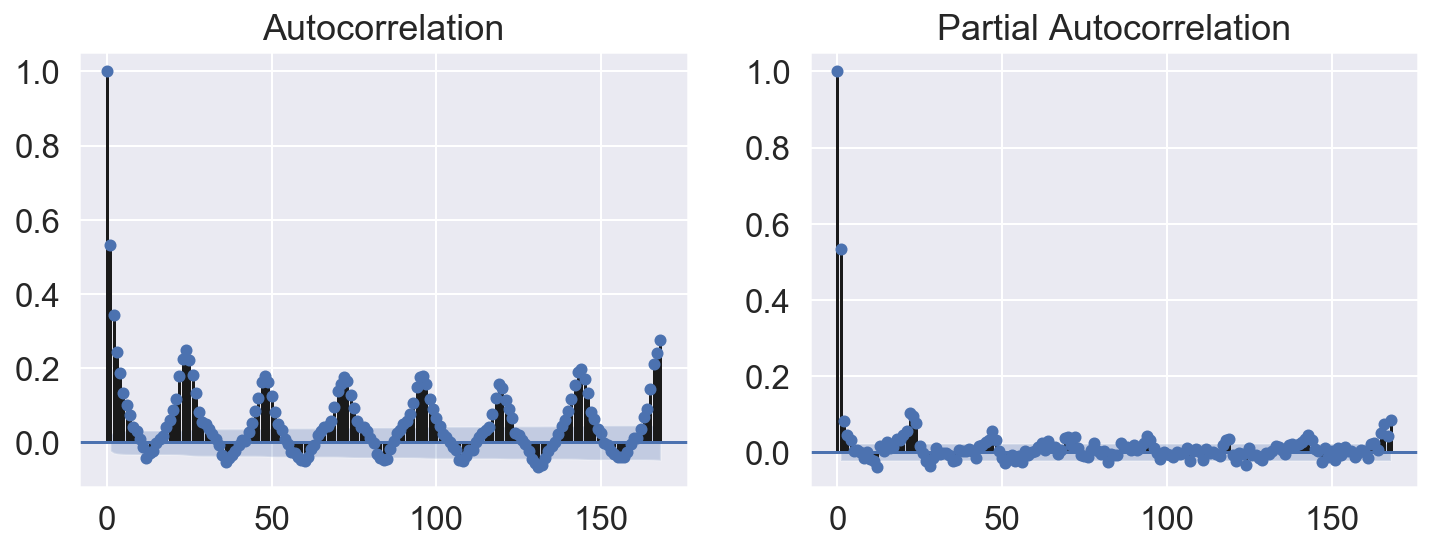

In [8]:
test_and_vis(rec_traffic.rec_games_count)

### Pro's online

Results of Dickey-Fuller Test:
Test Statistic                -8.333444e+00
p-value                        3.320761e-13
#Lags Used                     3.400000e+01
Number of Observations Used    7.530000e+03
Critical Value (1%)           -3.431219e+00
Critical Value (5%)           -2.861924e+00
Critical Value (10%)          -2.566974e+00
dtype: float64


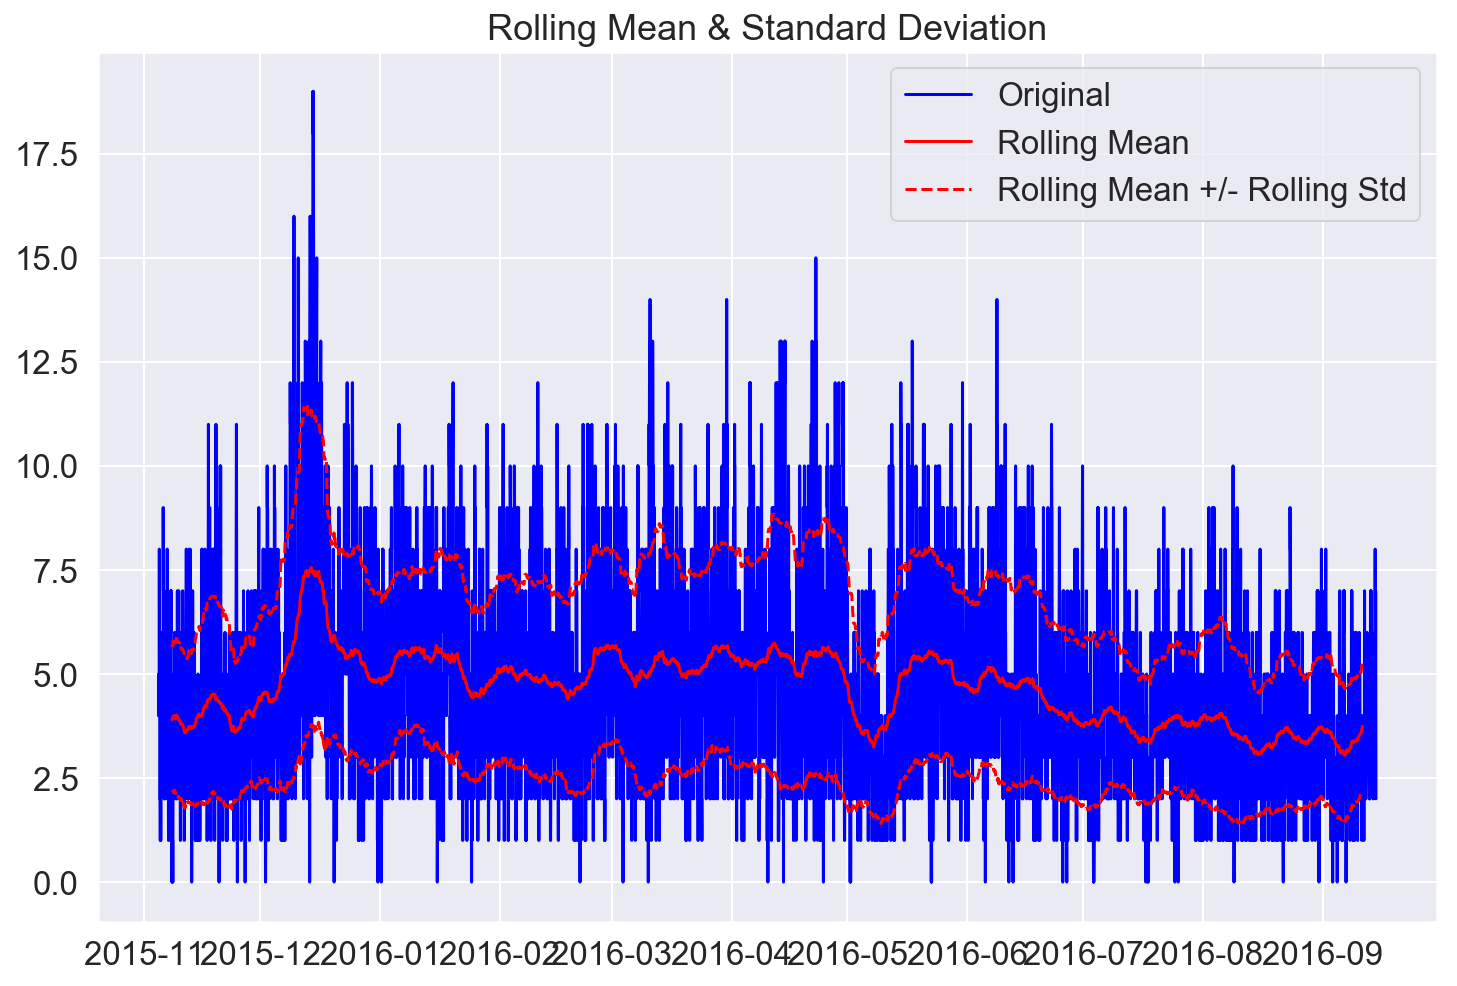

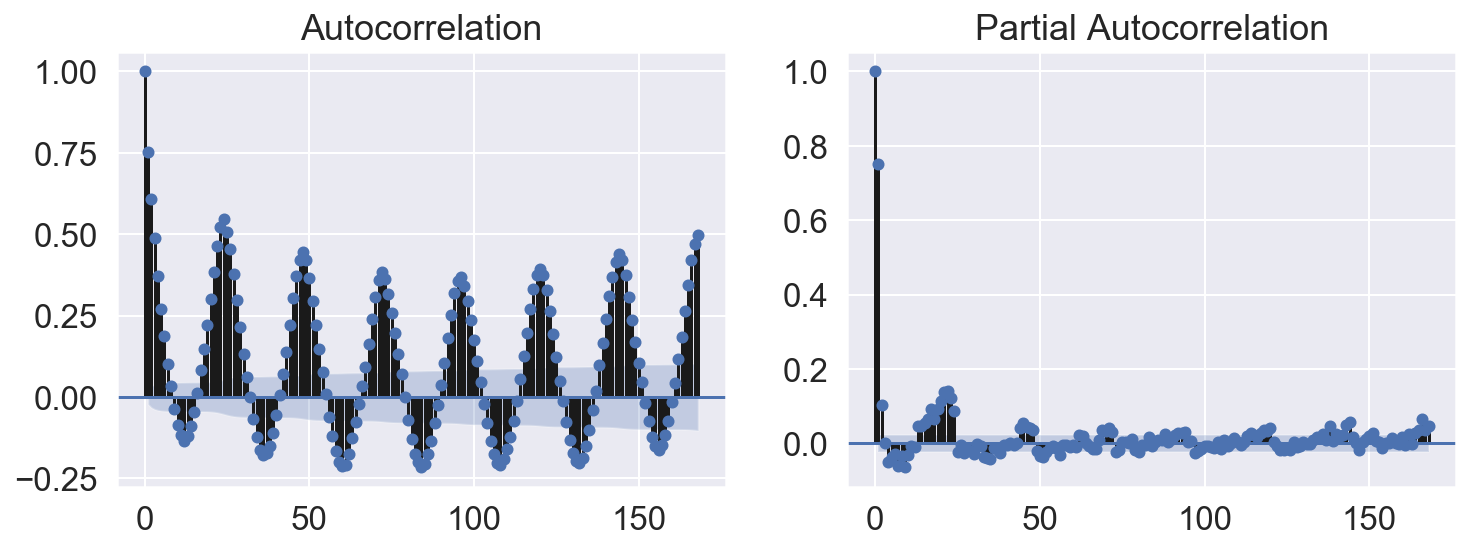

In [9]:
test_and_vis(pros_online.pros_online)

The p-value represents the probability of observing a test statistic greater than the test statistic output given the null hypothesis is true (the null hypothesis is that the mean is not stationary). In all three instances the probability of observing greater than test statistic given the null hypothesis is true is extremely small; we are confident we can effectively model on this representation of the time series (as opposed to a differenced version of the time series).

## One week or one day seasonality

We saw in the EDA that there was a daily and weekly seasonal component to the time series. We expect the benefit of a weekly seasonal component is that the model will capture the lower than expected traffic on a Sunday, the downside of this is that the moving average components of the a SARIMAX models will have more variance in them (because they are based on smaller sample sizes due to the wider group by). To decide between the two we will compare the Auto correlation values at lag 24 (one day) and lag 168 (one week).

In [10]:
#all traffic
print('One day lag: ', acf(all_traffic.all_games_count, nlags=168)[24])
print('One week lag: ', acf(all_traffic.all_games_count, nlags=168)[168])

One day lag:  0.302454627092786
One week lag:  0.299123418305589


In [11]:
#min one recreational player traffic
print('One day lag: ', acf(rec_traffic.rec_games_count, nlags=168)[24])
print('One week lag: ', acf(rec_traffic.rec_games_count, nlags=168)[168])

One day lag:  0.2479830711776104
One week lag:  0.2767276875877051


In [12]:
#pro online traffic
#min one recreational player traffic
print('One day lag: ', acf(pros_online.pros_online, nlags=168)[24])
print('One week lag: ', acf(pros_online.pros_online, nlags=168)[168])

One day lag:  0.5458181006819889
One week lag:  0.4960806391945656


Here we see that for pro's online and all traffic a daily seasonal component performs better, for recreational traffic a weekly seasonal component performs better. This is not surprising, we would expect those who are not professionals to have their playing hours more dictated by the regular schedules associated with the week.

## Time series decomposition 
It is difficult to make sense of an seasonal decomposition from a years worth of data, below is time series decomposition for the first quarter (of games) of the data set.

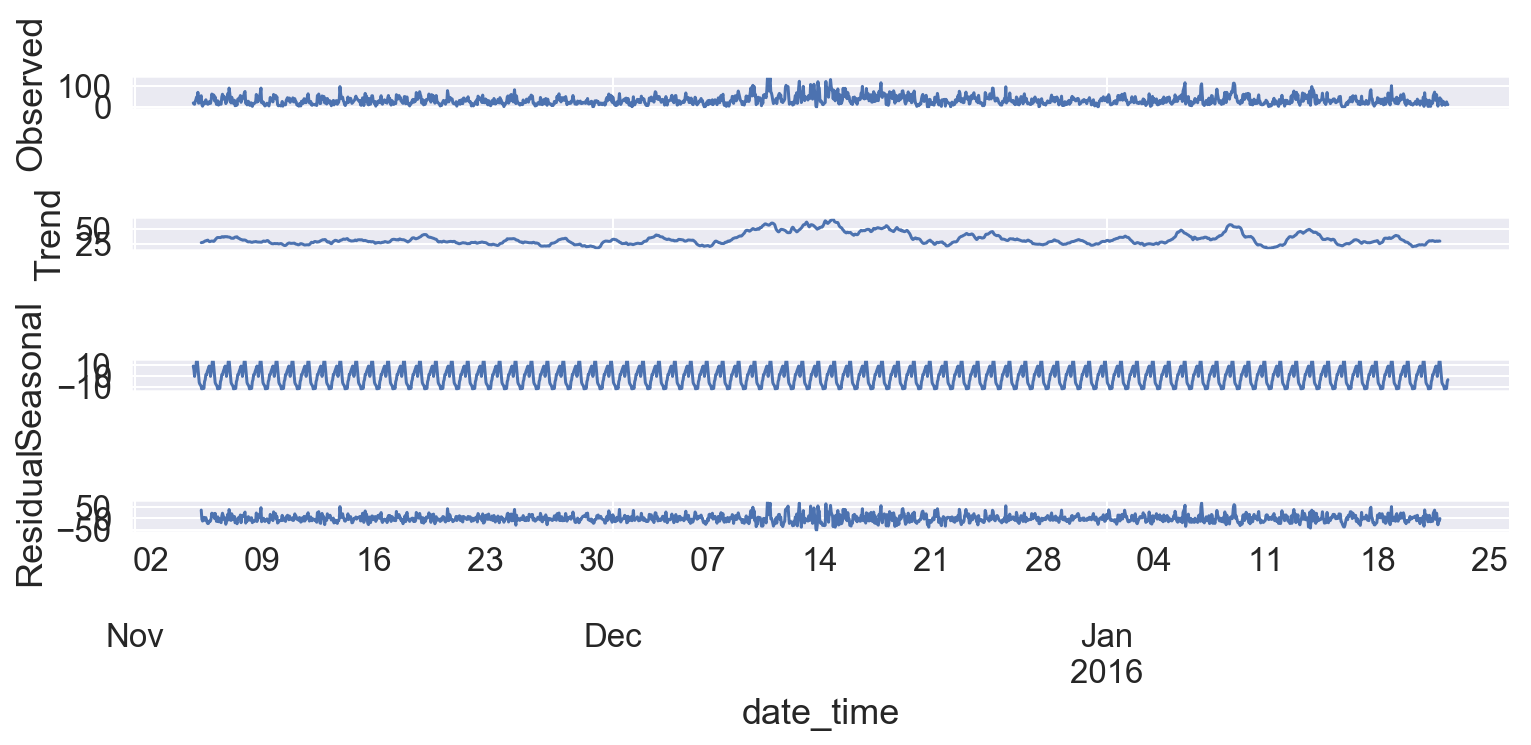

In [13]:
decomposition = seasonal_decompose(all_traffic.all_games_count[:int(round(len(all_traffic)/4))], freq=24)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

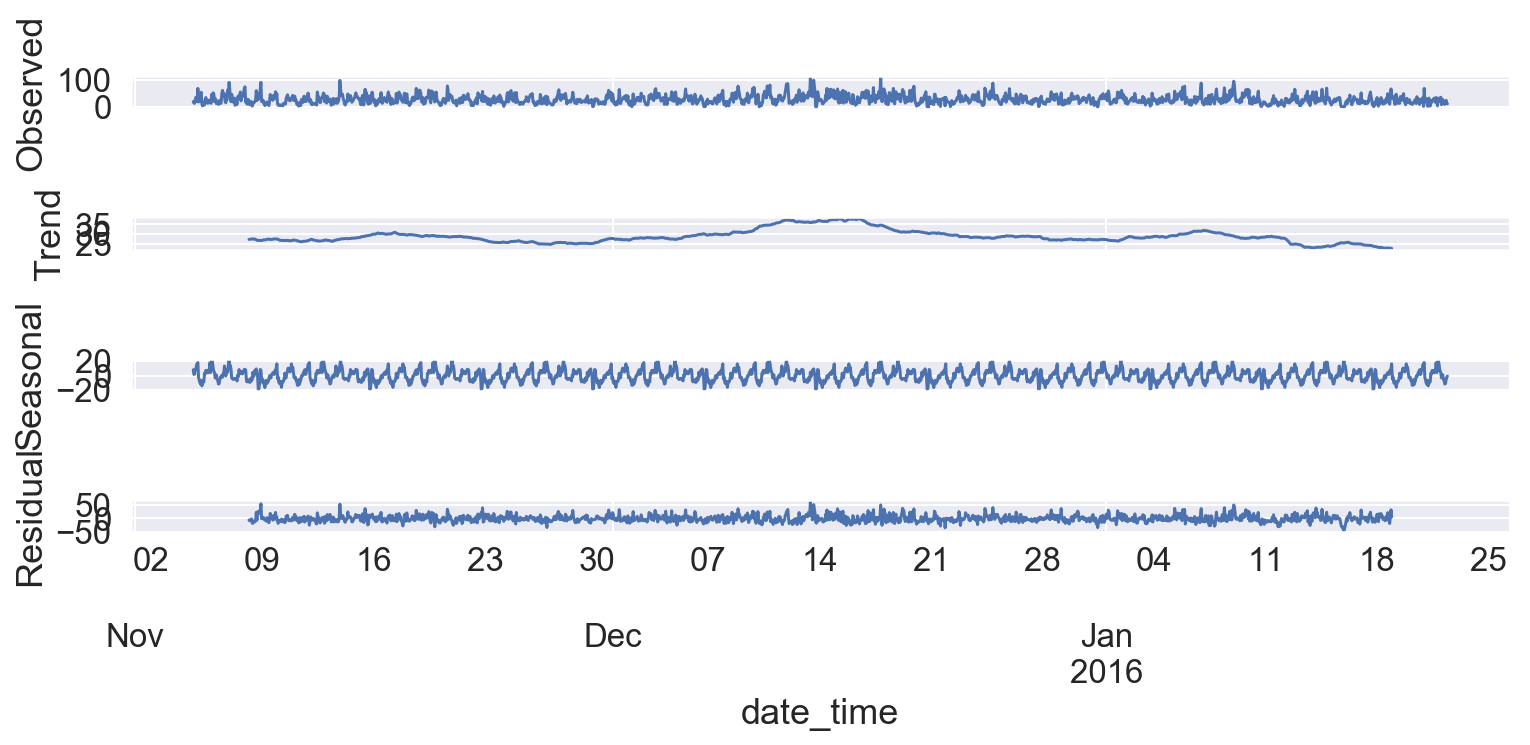

In [14]:
decomposition = seasonal_decompose(rec_traffic.rec_games_count[:int(round(len(rec_traffic)/4))], freq=168)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

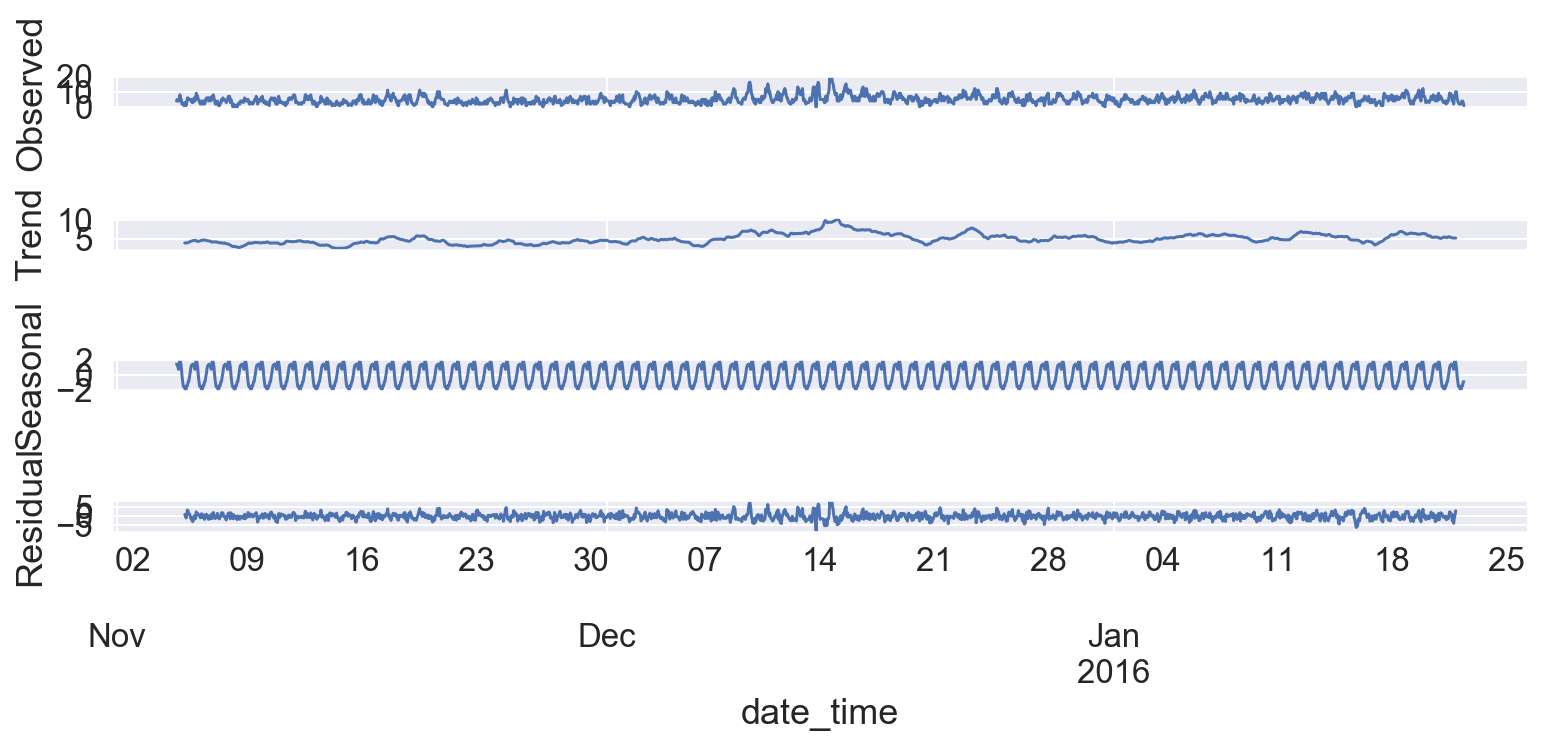

In [15]:
decomposition = seasonal_decompose(pros_online.pros_online[:int(round(len(pros_online)/4))], freq=24)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

## Implementing SARIMAX models

### Time series modelling and report functions

In [16]:
#Time series report function

def time_series_report (time_series, model, predictions=None):
    """"""
    
    #Info from model summary 
    report='\n\nSTATESPACE MODEL RESULTS AND DIAGNOSTICS\n'
    for i in (str(model.summary()).split('\n')[1:4]):
        report=report+i+('\n')
    report=report+('\n')
    for i in (str(model.summary()).split('\n')[10:]):
        if i[0]== '=':
            break
        else:
            report=report+i+('\n')
            
    print(report)
    
    #Rerunning models after each updated value is too computationally heavy.
    #Train models on first 80% of sample, test on last 20%
    
    #set test and train
    length_train=round(len(time_series)/5)
    train=time_series[:len(time_series)-length_train]
    test=time_series[len(time_series)-length_train:]
    preds = model.predict( dynamic=False)
    
    
    #Residuals and standardised residuals
    train_resid= model.resid[:len(time_series)-length_train]
    test_resid=model.resid[len(time_series)-length_train:]
    scaler=StandardScaler()
    test_stan_resid=pd.DataFrame(scaler.fit_transform(pd.DataFrame(test_resid)))
    test_stan_resid.index=test_resid.index
    test_stan_resid.columns=['resid_p']
    
    #residuals histogram
    plot_test_residuals=go.Histogram(x=test_resid)
    plot_train_residuals=go.Histogram(x=train_resid)

    #corellogram plot
    correl= pd.Series(acorr_ljungbox(model.resid, lags=10, boxpierce=True)[3])
    plot_correl=go.Bar(x=list(range(1,21)),
                       y=correl)

    #option resample standardised residuals to make clearer
    #test_stan_resid=test_stan_resid.resample('6H').mean()
    
    #standardised residuals line graph
    plot_sr=  go.Scatter(
                        x = test_stan_resid.index,
                        y = test_stan_resid.resid_p,
                        mode = 'lines',
                        name = 'Standardised residuals'
                    )

    fig = tools.make_subplots(rows=2, cols=2, print_grid=False, 
                              subplot_titles=('Train residuals distribution',
                                              'Corellogram - all residuals',
                                              'Test residuals distribution',
                                              'Standardised test residuals'
                                             ))
    
    fig.append_trace(plot_train_residuals, 1, 1)
    fig.append_trace(plot_test_residuals, 2, 1)
    fig.append_trace(plot_correl, 1, 2)
    fig.append_trace(plot_sr, 2, 2)
    fig['layout']['yaxis2'].update(title='P-value', range=[0, 1])
    fig['layout'].update(showlegend=False, title='DIAGNOSTICS')
    iplot(fig)
    
    print('QUANTILE PLOT - ALL RESIDUALS')
    fig = sm.qqplot(model.resid, stats.norm, fit=True, line='45')
    plt.show()
    return 

In [17]:
def baseline_vs_model(time_series, model):
    #uses mean of test set for all predictions
    
    #if option for resample is needed at arguement for resample in function
    #time_series=time_series.resample(resample).sum()
    
    length_train=round(len(time_series)/5)
    train=time_series[:len(time_series)-length_train]
    test = time_series[len(time_series)-length_train:]
    
    pred=[train.mean()]*(len(time_series)-length_train)
    
    train_mse=round(mean_squared_error(train, pred),4)
    train_mae=round(mean_absolute_error(train, pred),4)
    train_r2=round(r2_score(train, pred),4)
    
    pred=[train.mean()]*length_train
    test_mse=round(mean_squared_error(test, pred),4)
    test_mae=round(mean_absolute_error(test, pred),4)
    test_r2=round(r2_score(test, pred),4)
    data={'Base_train': [train_mse, train_mae, train_r2], 
          'Base_test': [test_mse, test_mae, test_r2 ]}
    
    #model predictions
    preds = model.predict(dynamic=False)
    
    #model test scores
    train_preds=preds[:len(time_series)-length_train]
    train_mse=round(mean_squared_error(train, train_preds),4)
    train_mae=round(mean_absolute_error(train, train_preds),4)
    train_r2=round(r2_score(train, train_preds),4)
    data['Model_train']=[train_mse, train_mae, train_r2]
    
    #model test scores
    test_preds=preds[len(time_series)-length_train:]
    test_mse=round(mean_squared_error(test, test_preds),4)
    test_mae=round(mean_absolute_error(test, test_preds),4)
    test_r2=round(r2_score(test, test_preds),4)
    data['Model_test']=[test_mse, test_mae, test_r2 ]
    
    data=pd.DataFrame(data)
    data.index=['MSE', 'MAE', 'R^2']

    
    print(data)
    return data

In [18]:
def model_test(time_series, olag, oma, solag, soma, season, freq):
    """ time_series= column used for prediction
    olag= order lag
    oma=order moving average
    solag=seasonal order lag
    soma = seasonal order moving average
    season = seasons component - should be day or week
    freq= frequency for resample, same as input for resample function"""
    time_series=time_series.resample(freq).sum()
        
    length_train=round(len(time_series)/5)
    train=time_series[:len(time_series)-length_train]

    #obtain model parameters using training set
    tmodel = sm.tsa.statespace.SARIMAX(train,
                                      order=(olag, 0, oma),
                                      seasonal_order=(solag, 0, soma, season),
                                      freq=freq)
    results = tmodel.fit(max_iter=1000)

    #use previous model parameters, add test set to sata to allow for predictions
    model = sm.tsa.statespace.SARIMAX(time_series,
                                      order=(olag, 0, oma),
                                      seasonal_order=(solag, 0, soma, season),
                                     freq=freq)
    final_model=model.filter(results.params)
    
    baseline_vs_model(time_series, final_model)
    
    time_series_report(time_series, final_model)
    
    return final_model

## Experiment with model parameters 

The SARIMAX model does not have a built in grid search feature. To optimise we run for loops with different parameters and evaluate the time series model reports. The output for this is very verbose, for loops have been run in separate notebooks (4a-c), with optimised models shown below.

The Time Series report uses the mean of the train set as a baseline prediction. All baseline models performed poorly, so we will evaluate a forward fill baseline model also (predict the next hour as having traffic equal to the previous hour).

Resampling for larger time winodows did nothing to improve the performance models. Models for two hour windows generally performed the same as models with one hour windows (or worse due to overfitting on training set). Models with four hour windows were unable to converge in many cases or would throw errors, this was likely due to the reduced size of training/test sets associated the smaller sample (1/4 the size of one hour window training and test sets).

Where there was nominal difference between scores for additional lags or moving averages, we prefer using less variables to cut down on run time - an important consideration when putting the model to use. Models that run faster can be easily retrained between observations and give more room for customisation by users.

### All traffic
#### Forward fill baseline

In [19]:
#starting index of test set
lt=round(len(all_traffic.all_games_count)/5)*4

In [20]:
#Forward fill baseline for test set
print('MSE: ',mean_squared_error(all_traffic.all_games_count[lt:],all_traffic.all_games_count.shift(1)[lt:]))
print('MAE: ',mean_absolute_error(all_traffic.all_games_count[lt:],all_traffic.all_games_count.shift(1)[lt:]))
print('r2: ',r2_score(all_traffic.all_games_count[lt:],all_traffic.all_games_count.shift(1)[lt:]))


MSE:  189.0515532055519
MAE:  10.235955056179776
r2:  0.05500751411157567


Models performed best when given at least one order and moving average and one seasons order and moving average.
Some models using multiple moving averages failed to converge and many showed significant correlation between residuals.

The residuals on the test set are slightly skewed and the peak below 0 indicates a tendency to overestimate. This is not surprising given the mean games per hour of the training set is higher than that of the test set. We would expect some of this bias to fall away when training the model on larger samples.

Models that converged that used greater than 1 for both orders and moving averages generally performed the same.

#### Best model

     Base_train  Base_test  Model_train  Model_test
MSE    281.1680   220.2957     173.8203    136.4827
MAE     12.7676    12.2179       9.9781      8.9081
R^2      0.0000    -0.1012       0.3818      0.3178


STATESPACE MODEL RESULTS AND DIAGNOSTICS
Dep. Variable:                    all_games_count   No. Observations:                 7565
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -30078.094

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4073      0.010    138.337      0.000       1.387       1.427
ar.L2         -0.4133      0.010    -41.874      0.000      -0.433      -0.394
ma.L1         -0.9537      0.005   -177.394      0.000      -0.964      -0.943
ar.S.L24       0.9972      0.001   1238.912      0.000       0.996       0.999
ma.S.L24      -0.9705      0.004   -248.407      0.000      -0.978      -0.963
sigma2       

QUANTILE PLOT - ALL RESIDUALS


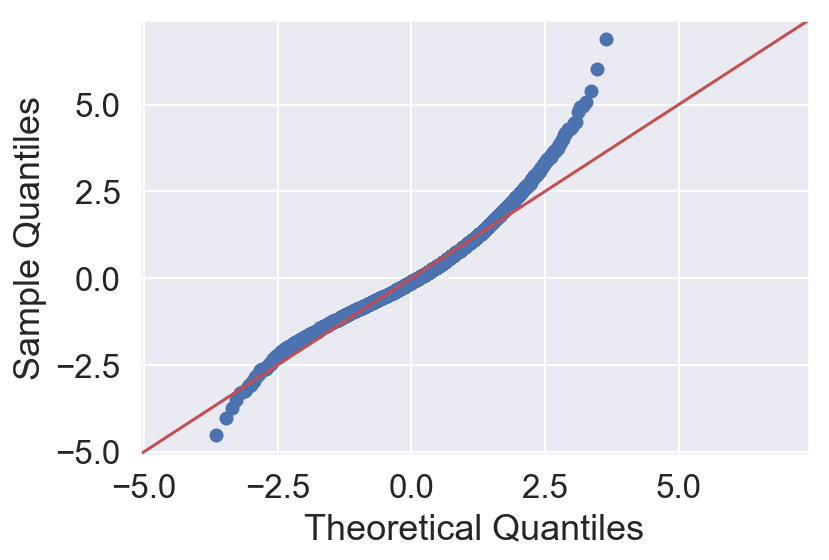

In [21]:
all_model=model_test(all_traffic.all_games_count,2,1,1,1,24,'H')

### Recreational traffic
#### Forward fill baseline
Attempting to model with a one week season component made the model unable to converge - the training has approximately 40 weeks in it, so sample size could be the issue. Parameters were changed to give one day seasonality.

In [22]:
#Forward fill baseline
print('MSE: ',mean_squared_error(rec_traffic.rec_games_count[lt:],rec_traffic.rec_games_count.shift(1)[lt:]))
print('MAE: ',mean_absolute_error(rec_traffic.rec_games_count[lt:],rec_traffic.rec_games_count.shift(1)[lt:]))
print('r2: ',r2_score(rec_traffic.rec_games_count[lt:],rec_traffic.rec_games_count.shift(1)[lt:]))


MSE:  147.85393258426967
MAE:  9.305353602115003
r2:  0.00709456002598452


The forward fill baseline performs worse for recreational traffic than it does for all traffic. This is somewhat surprising, we were expecting the recreational traffic to have more regularity to it and so have a better performing baseline.

Again models perform best with at least one moving average component for lag and seasonal lag.

The residuals have a more normal distribution than the model for all traffic. The mean absolute and mean squared error are smaller for recreational only traffic, despite this the r2 score is lower, this is due to the lower variance in the recreational traffic time series.

Models that converged that used greater than 1 for both orders and moving averages generally performed the same.

#### Best model

     Base_train  Base_test  Model_train  Model_test
MSE    210.6099   166.1469     141.2336    105.3998
MAE     11.3302    10.7925       9.1271      8.0541
R^2      0.0000    -0.1158       0.3294      0.2922


STATESPACE MODEL RESULTS AND DIAGNOSTICS
Dep. Variable:                    rec_games_count   No. Observations:                 7565
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -29260.016

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4013      0.012    112.111      0.000       1.377       1.426
ar.L2         -0.4064      0.011    -35.681      0.000      -0.429      -0.384
ma.L1         -0.9591      0.007   -140.606      0.000      -0.972      -0.946
ar.S.L24       0.9983      0.001   1873.142      0.000       0.997       0.999
ma.S.L24      -0.9779      0.004   -278.888      0.000      -0.985      -0.971
sigma2       

QUANTILE PLOT - ALL RESIDUALS


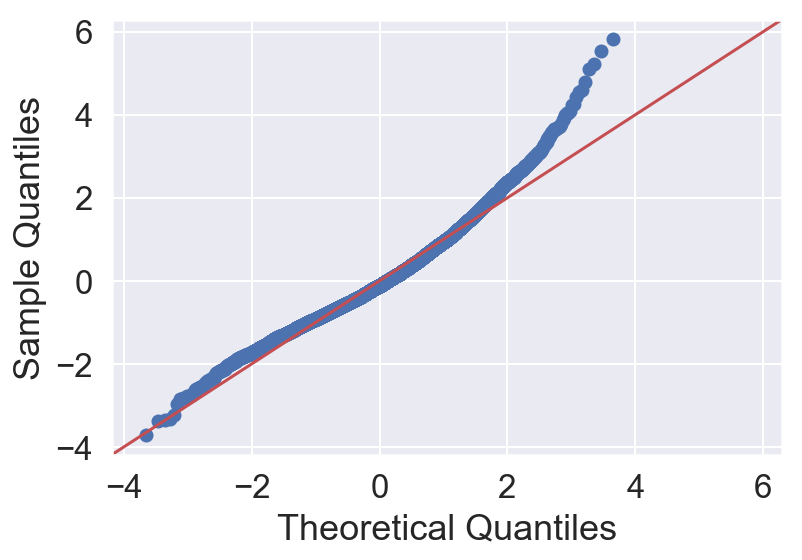

In [23]:
rec_model=model_test(rec_traffic.rec_games_count,2,1,1,1,24,'H')

### Pro's online
#### Forward fill baseline

In [24]:
#Forward fill baseline
print('MSE: ',mean_squared_error(pros_online.pros_online[lt:],pros_online.pros_online.shift(1)[lt:]))
print('MAE: ',mean_absolute_error(pros_online.pros_online[lt:],pros_online.pros_online.shift(1)[lt:]))
print('r2: ',r2_score(pros_online.pros_online[lt:],pros_online.pros_online.shift(1)[lt:]))


MSE:  2.0218109715796433
MAE:  1.047587574355585
r2:  0.3485259631490788


The forward fill baseline performs very well here compared to previous baselines and scores. Professionals online in any hour is the most predictable component of the traffic data.

The model test function was altered to take the mean when resampling (this removes the issue of counting the same reg twice in a resampled window). The model failed to converge for any time window greater than one hour.

The score on training data show an improvement over the forward fill baseline r2 score on all data. We would expect this model to perform marginally better than the baseline - we note that there is no correlation between residuals, which have a close to normal distribution.

#### Best model

     Base_train  Base_test  Model_train  Model_test
MSE      6.2101     4.8749       2.3458      1.5078
MAE      1.9830     1.8656       1.1769      0.9519
R^2      0.0000    -0.5708       0.6223      0.5142


STATESPACE MODEL RESULTS AND DIAGNOSTICS
Dep. Variable:                        pros_online   No. Observations:                 7565
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 24)   Log Likelihood              -13688.828

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4952      0.014    106.292      0.000       1.468       1.523
ar.L2         -0.5041      0.013    -39.228      0.000      -0.529      -0.479
ma.L1         -0.9306      0.009   -100.687      0.000      -0.949      -0.912
ar.S.L24       1.0648      0.006    180.952      0.000       1.053       1.076
ar.S.L48      -0.0661      0.006    -11.519      0.000      -0.077      -0.055
ma.S.L24     

QUANTILE PLOT - ALL RESIDUALS


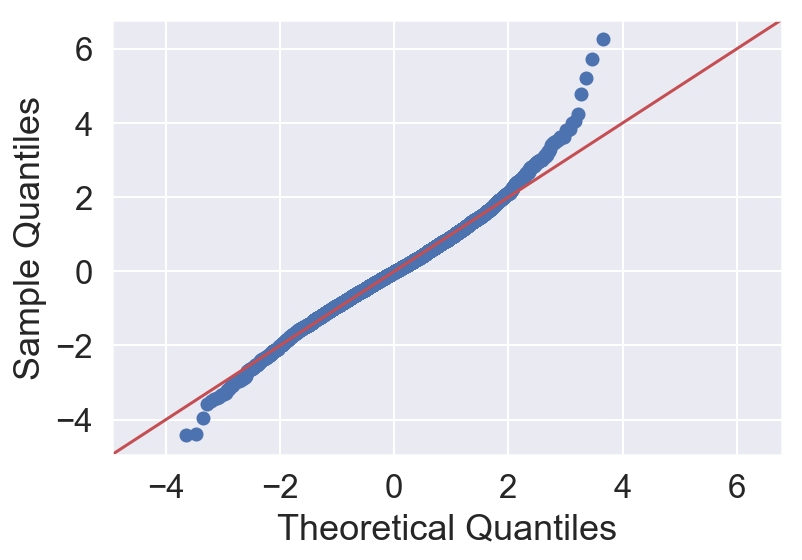

In [25]:
pro_model=model_test(pros_online.pros_online,2,1,2,1,24,'H')

# Model roundup

Compare accuracy scores and evaluate one step ahead and 2 step ahead forecasts.


In [26]:
test_start=len(all_traffic.all_games_count)-round(len(all_traffic.all_games_count)/5)

In [27]:
def real_v_pred(data, model, title):
    # Create traces
    trace0 = go.Scatter(
        x = data.index[test_start:],
        y = data[test_start:],
        mode = 'lines',
        name = 'Real'
    )
    trace1 = go.Scatter(
        x = data.index[test_start:],
        y = model.predict()[test_start:],
        mode = 'lines',
        name = 'Predicted'
    )

    layout= go.Layout(
        title= 'Real vs predicted: '+title,
        hovermode= 'closest',
        xaxis= dict(
            title= 'Date',
            ticklen= 5,
            gridwidth= 2,
        ),
        yaxis=dict(
            title= 'Count',
            ticklen= 5,
            gridwidth= 2,
        ),
    )

    data = [trace0, trace1]
    fig= go.Figure(data=data, layout=layout)
    iplot(fig)

In [28]:
def step_ahead_predictions(timeseries, model, steps_ahead):
    "function viable for up to 8 steps ahead"
    d={'step_{}_predictions'.format(steps_ahead):[],
      'real_values':[]}

    test_start=round(len(timeseries)*.8)
    for i in range(test_start, (len(timeseries)-10)):
        d['step_{}_predictions'.format(steps_ahead)].append(model.predict(start=timeseries[i:].index.min(),
                                                            end=timeseries[:(i+10)].index.max(),
                                                            dynamic=True)[steps_ahead-1])
       
        d['real_values'].append(timeseries[i+steps_ahead-1])
        
    dataframe=pd.DataFrame(d, index=timeseries[(test_start+steps_ahead-1):(len(all_traffic)-11+steps_ahead)].index)
    
    print('r2 score: ',r2_score(dataframe.real_values, dataframe['step_{}_predictions'.format(steps_ahead)]))
    
        # Create traces
    trace1 = go.Scatter(
        x = dataframe.index,
        y = dataframe['step_{}_predictions'.format(steps_ahead)],
        mode = 'lines',
        name = 'Predicted'
    )
    trace0 = go.Scatter(
        x = dataframe.index,
        y = dataframe.real_values,
        mode = 'lines',
        name = 'Real'
    )

    layout= go.Layout(
        title= 'Real vs predicted, {} steps ahead'.format(steps_ahead),
        hovermode= 'closest',
        xaxis= dict(
            title= 'Date',
            ticklen= 5,
            gridwidth= 2,
        ),
        yaxis=dict(
            title= 'Count',
            ticklen= 5,
            gridwidth= 2,
        ),
    )

    data = [trace0, trace1]
    fig= go.Figure(data=data, layout=layout)
    iplot(fig)
    
    return #dataframe


#### All traffic 
    - Forward fill baseline r2: 0.06
    - Model test set r2:        0.32

#### Recreational traffic 
    - Forward fill baseline r2: 0.01
    - Model test set r2:        0.29

#### Pros online 
    - Forward fill baseline r2: 0.30
    - Model test set r2:        0.51
    
All models provide an improvement on the baseline, although the latter two provide a lower improvement on the baseline, they have a more normal distribution of residuals - a key success metric for the models.

#### All traffic

In [29]:
real_v_pred(all_traffic.all_games_count, all_model, 'All traffic')

In [30]:
step_ahead_predictions(all_traffic.all_games_count, all_model, 2)

r2 score:  0.18946985219982881


#### Recrational traffic

In [31]:
real_v_pred(rec_traffic.rec_games_count, rec_model, 'Recreational traffic')

In [32]:
step_ahead_predictions(rec_traffic.rec_games_count, rec_model, 2)

r2 score:  0.15477510930716254


#### Pros online

In [33]:
real_v_pred(pros_online.pros_online, pro_model, 'Professionals online')

In [34]:
step_ahead_predictions(pros_online.pros_online, pro_model, 2)

r2 score:  0.3859144264365567


# Conclusion

All models provide an improvement on the baseline prediction of the previous hours value. As evident from the variance in returns, professional poker players often take the long view when factoring variance into their decision making process. Because of this, we consider the r2 score of .3 and normally distributed residuals a promising start for a commercially viable product. 

Because the models don't require many lags they train relatively fast and are capable of being updated at every time interval. Giving the user the option to toggle professional/recreational classifications and time windows could also result in further improvements on the models performance or commercial viability. 

We expect the models would improve in accuracy if provided with a larger data sets to train on.

Steps ahead models saw a drop in the r2 score, they were less capable of predicting large spikes or drops in traffic. Further evaluation of the models is needed to establish if they can be considered commercially viable.






